In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rakeshsuru16
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:03<00:00, 190MB/s] 


In [3]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available: ", device)

Device available:  cuda


In [5]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir("/content/animal-faces/afhq/" + i):
    for image in os.listdir("/content/animal-faces/afhq/" + i + "/" + label):
      image_path.append("/content/animal-faces/afhq/" + i + "/" + label + "/" + image)
      labels.append(label)

data = pd.DataFrame(zip(image_path, labels), columns = ["image_path", "labels"])

In [6]:
data.head()

,image_path,labels
0,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
1,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
2,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
3,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
4,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat


In [7]:
data["labels"].unique()

array(['cat', 'wild', 'dog'], dtype=object)

In [8]:
train = data.sample(frac = 0.7)
test = data.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

In [9]:
train.shape, val.shape, test.shape

((11291, 2), (2420, 2), (2419, 2))

In [10]:
le = LabelEncoder()
le.fit(data["labels"])

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(le.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label

In [12]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

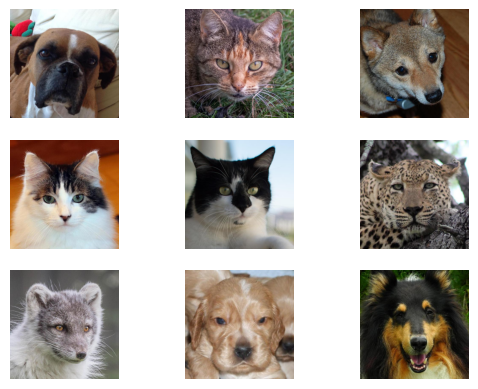

In [13]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(data.sample(n = 1)['image_path'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

In [14]:
LR = 1e-4
BATCH_SIZE = 64
EPOCHS = 10

In [15]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
      self.pooling = nn.MaxPool2d(2,2)
      self.relu = nn.ReLU()

      self.flatten = nn.Flatten()
      self.linear = nn.Linear((128 * 16 * 16), 128)
      self.output = nn.Linear(128, len(data['labels'].unique()))


    def forward(self, x):
      x = self.conv1(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device)

In [17]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [19]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)

Epoch 1/10, Train Loss: 1.228 Train Accuracy 69.4535
              Validation Loss: 0.1467 Validation Accuracy: 86.5289
Epoch 2/10, Train Loss: 0.5271 Train Accuracy 89.0798
              Validation Loss: 0.0984 Validation Accuracy: 90.6198
Epoch 3/10, Train Loss: 0.3714 Train Accuracy 92.3922
              Validation Loss: 0.0763 Validation Accuracy: 92.6446
Epoch 4/10, Train Loss: 0.3034 Train Accuracy 93.8447
              Validation Loss: 0.0675 Validation Accuracy: 93.4298
Epoch 5/10, Train Loss: 0.2419 Train Accuracy 95.0757
              Validation Loss: 0.0573 Validation Accuracy: 94.5041
Epoch 6/10, Train Loss: 0.1967 Train Accuracy 96.0942
              Validation Loss: 0.0703 Validation Accuracy: 92.8926
Epoch 7/10, Train Loss: 0.1829 Train Accuracy 96.3511
              Validation Loss: 0.0528 Validation Accuracy: 94.9587
Epoch 8/10, Train Loss: 0.1515 Train Accuracy 97.1659
              Validation Loss: 0.0531 Validation Accuracy: 95.0413
Epoch 9/10, Train Loss: 0.1312 Tr

In [20]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 94.8739 and Loss is 0.0054


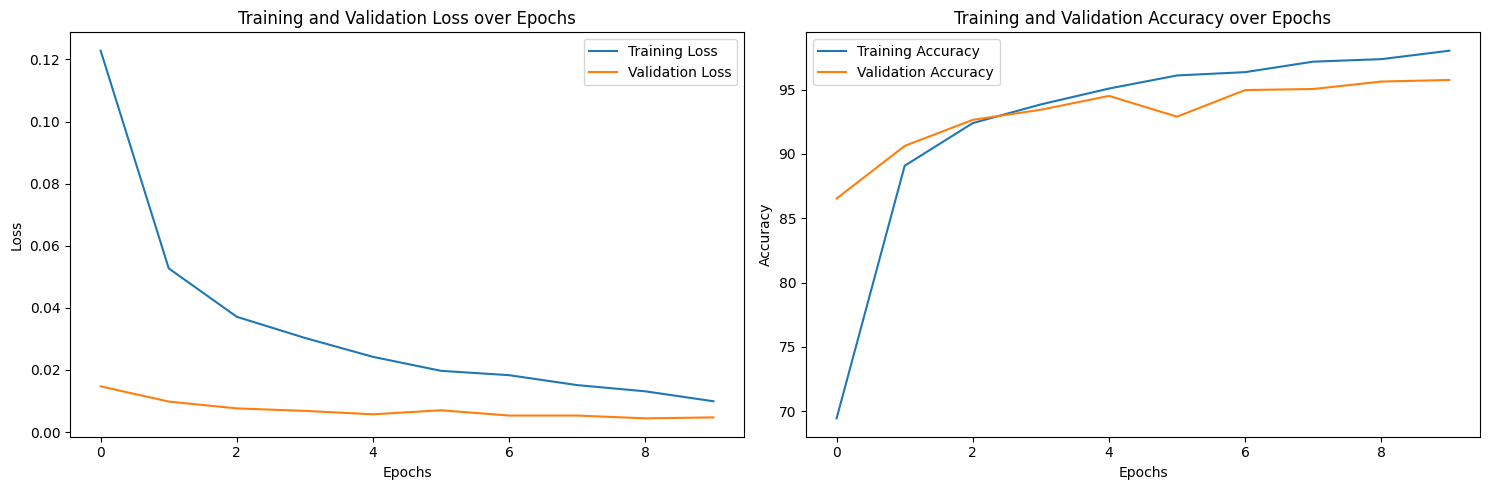

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

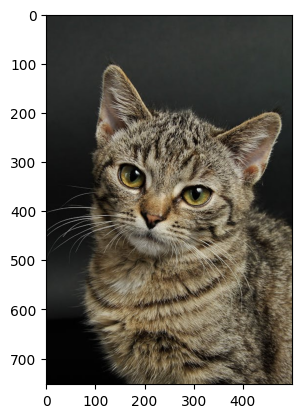


Prediction: 



array(['cat'], dtype=object)

In [22]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return le.inverse_transform([output])

image = Image.open("/content/pexels-photo-2071882.jpeg")
plt.imshow(image)
plt.show()

print()
print("Prediction: \n")
predict_image("/content/pexels-photo-2071882.jpeg")

In [23]:
import torch

model.eval()
example = torch.randn(1, 3, 128, 128)
ts_model = torch.jit.trace(model.cpu(), example)
ts_model.save("afhq_cnn_ts.pt")
print("Saved TorchScript model -> afhq_cnn_ts.pt")


Saved TorchScript model -> afhq_cnn_ts.pt
